In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available else "NOT AVAILABLE")

TF version: 2.10.0
GPU is available


In [2]:
import numpy as np
import IPython.display as display
import PIL.Image
from keras.preprocessing import image

In [3]:
# 图像标准化
def normalize_image(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# 图像可视化
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# 保存图像文件
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save('save/' + file_name)

In [4]:
# 导入ImageNet数据集的图像识别预训练InceptionV3模型
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model.summary()

Metal device set to: Apple M1 Pro


2022-11-11 10:33:46.988627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 10:33:46.988742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [5]:
# 最大限度地激活这些层的指定的层
layer_names = ['conv2d_15', 'conv2d_18']
layers = [base_model.get_layer(name).output for name in layer_names]
layers

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_15')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_18')>]

In [6]:
# 创建特征提取模型
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [7]:
def calc_loss (img, model):
    # 对图象做变形，由 （300，300，3）扩展为（1，300,300, 3)
    img = tf.expand_dims(img, axis=0)
    # 图像通过模型前向传播得到计算结果
    layer_activations = model(img)

    losses = []
    for act in layer_activations:
        losses.append(tf.math.reduce_mean(act))
    # 选中通道的粉出结果求均值
    return tf.reduce_mean(losses)

# 定义图像优化过程函数
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            # 对img进行梯度变换
            tape.watch(img)
            loss = calc_loss(img, model)
        # 计算损失相对于粉入图像像素的梯度
        gradients = tape.gradient(loss, img)
        # 归一化梯度值
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        # 在梯度上开中，损失值越来越大，因此可以直接添加损失值到图像中， 因为它们的shape相同
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)
        # 粉出过程提示信息
        if verbose ==1:
            if (n + 1) %10==0:
                print ("Step {}/{}, loss {})". format (n+1, steps, loss))
    return img

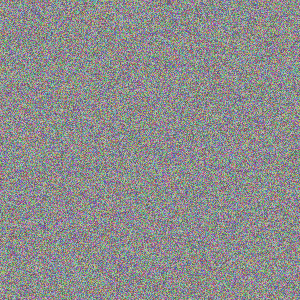

In [9]:
# 定义图像燥声
img_noise = np.random.uniform (size= (300, 300, 3)) + 100.0
img_noise = img_noise.astype(np. float32)  # dtype 转换成 float32
show_image(normalize_image(img_noise))

img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

开始做梦...
Step 10/100, loss -0.1616370677947998)
Step 20/100, loss -0.13470299541950226)
Step 30/100, loss -0.11869111657142639)
Step 40/100, loss -0.10432668775320053)
Step 50/100, loss -0.0932699665427208)
Step 60/100, loss -0.08518693596124649)
Step 70/100, loss -0.07882112264633179)
Step 80/100, loss -0.07267577946186066)
Step 90/100, loss -0.06710165739059448)
Step 100/100, loss -0.06268665939569473)
梦醒时分... 耗时: 5.410397291183472


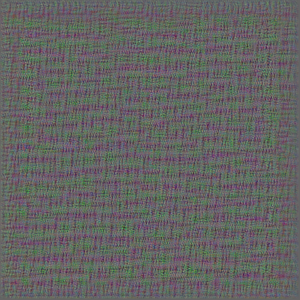

梦境已保存为:deep_dream_['conv2d_15', 'conv2d_18'].jpg


In [10]:
import time

start = time.time()
print('开始做梦...')

# 调用优化过程
dream_img = render_deepdream(dream_model, img, steps=100, step_size=0.01)

end = time.time()
print('梦醒时分... 耗时:', end - start)

# 标准化图像
dream_img = normalize_image(dream_img)

# 显示结果图像
show_image(dream_img)

# 保存结果
file_name = 'deep_dream_{}.jpg'.format(layer_names)
save_image(dream_img, file_name)
print('梦境已保存为:{}'.format(file_name))

In [8]:
def read_image(file_name, max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

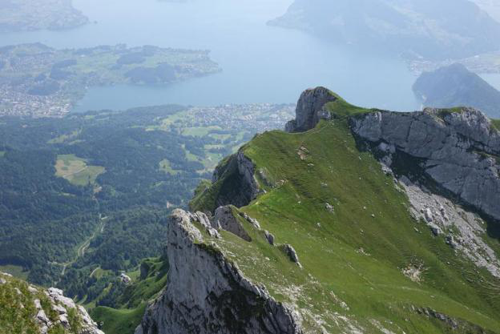

In [9]:
image_file = 'mountain.jpg'
img_mountain = read_image('data/' + image_file, max_dim=500)
show_image(img_mountain)

img = tf.keras.applications.inception_v3.preprocess_input(img_mountain)
img = tf.convert_to_tensor(img)

开始做梦...
Step 10/100, loss -0.228181391954422)
Step 20/100, loss -0.1867177039384842)
Step 30/100, loss -0.16254162788391113)
Step 40/100, loss -0.14600670337677002)
Step 50/100, loss -0.13303400576114655)
Step 60/100, loss -0.1227124035358429)
Step 70/100, loss -0.1142350435256958)
Step 80/100, loss -0.10717263072729111)
Step 90/100, loss -0.10088661313056946)
Step 100/100, loss -0.09575383365154266)
梦醒时分... 耗时: 5.067189931869507


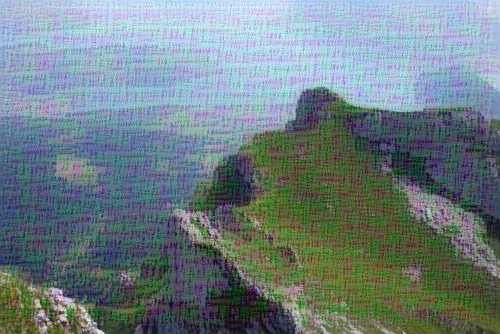

梦境已保存为:mountain_deep_dream_['conv2d_15', 'conv2d_18'].jpg


In [10]:
import time

# 不同比例迭代进行
start = time.time()
print('开始做梦...')

# 调用优化过程
dream_img = render_deepdream(dream_model, img, steps=100, step_size=0.01)

end = time.time()
print('梦醒时分... 耗时:', end - start)

# 标准化图像
dream_img = normalize_image(dream_img)

# 显示结果图像
show_image(dream_img)

# 保存结果
file_name = 'mountain_deep_dream_{}.jpg'.format(layer_names)
save_image(dream_img, file_name)
print('梦境已保存为:{}'.format(file_name))

Step 10/30, loss -0.22138415277004242)
Step 20/30, loss -0.18074966967105865)
Step 30/30, loss -0.1564069539308548)
Step 10/30, loss -0.1768331676721573)
Step 20/30, loss -0.15127208828926086)
Step 30/30, loss -0.13496264815330505)
Step 10/30, loss -0.17269732058048248)
Step 20/30, loss -0.1484105885028839)
Step 30/30, loss -0.13212493062019348)
Step 10/30, loss -0.16928178071975708)
Step 20/30, loss -0.14653460681438446)
Step 30/30, loss -0.1317322999238968)
Step 10/30, loss -0.1726187914609909)
Step 20/30, loss -0.1496598720550537)
Step 30/30, loss -0.13496068120002747)


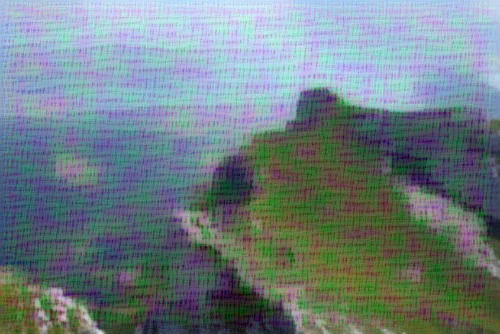

耗时： 9.43867015838623
梦境已保存为:mountain_deep_dream_optimization1_['conv2d_15', 'conv2d_18'].jpg


In [12]:
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.keras.applications.inception_v3.preprocess_input(img_mountain)
img = tf.convert_to_tensor(img)

initial_shape = tf.shape(img)[:-1]

# 从小到大比勿进行多次优化过程
for octave in range(-2, 3):
    new_size = tf.cast(tf.convert_to_tensor(initial_shape), tf.float32) * (OCTAVE_SCALE**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))
    img = render_deepdream(dream_model, img, steps=30, step_size=0.01)

# 把图调整回原始大小
img = tf.image.resize(img, initial_shape)
# 标准化图像
img= normalize_image(img)
show_image(img)

end = time.time()
print('耗时：', end-start)

# 保存结果
file_name = 'mountain_deep_dream_optimization1_{}.jpg'.format(layer_names)
save_image(dream_img, file_name)
print('梦境已保存为:{}'.format(file_name))

tf.Tensor([-167  349], shape=(2,), dtype=int32)
tf.Tensor(-167, shape=(), dtype=int32) tf.Tensor(349, shape=(), dtype=int32)
tf.Tensor(-167, shape=(), dtype=int32) tf.Tensor(349, shape=(), dtype=int32)


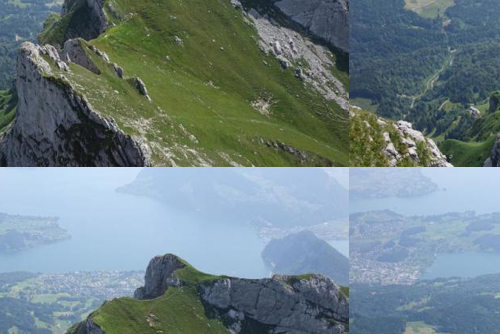

In [13]:
# 定义图像切分移动函数
def random_roll(img, maxrol1=512):
    # 随机移动图像
    shift = tf.random.uniform(shape=[2], minval=-maxrol1, maxval=maxrol1, dtype=tf.int32)
    print(shift)
    shift_down, shift_right = shift[0], shift[1]
    print(shift_down, shift_right)
    img_rolled = tf.roll(tf. roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

shift_down, shift_right, img_rolled = random_roll(np.array(img_mountain), 512)
print(shift_down, shift_right)
show_image (img_rolled)

In [14]:
# 定义分块计算的梯度函数
# 求梯度
def get_tiled_gradients(model, img, tile_size=150):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)
    # 初始化梯度为0
    gradients = tf.zeros_like(img_rolled)
    # 产生分块坐标列表
    xs = tf.range(0, img_rolled. shape[0], tile_size)
    ys = tf.range(0, img_rolled. shape[1], tile_size)

    for x in xs:
        for y in ys:
            # 计算该图块的梯度
            with tf.GradientTape() as tape:
                tape.watch(img_rolled)
                # 从图像中提取该图块，最后一块大小会按实际提级
                img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                loss = calc_loss (img_tile, model)
                # 更新图像的梯度
                gradients = gradients + tape.gradient(loss, img_rolled)
    # 将图块放回原来的位置
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
    # 归一化梯度
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    return gradients

In [15]:
# 定义优化后的Deep Dream函数
def render_deepdream_with_octaves(model, img, steps_per_octave=100, step_size=0.01,octaves=range (-2, 3), octave_scale=1.3):
    initial_shape = img.shape[: -1]
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(initial_shape), tf.float32) * (octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range (steps_per_octave):
            gradients = get_tiled_gradients(model, img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            if (step + 1)%10==0:
                print ("Octave {}, Step {}".format (octave, step+1))
    img = tf.image.resize(img, initial_shape)
    result = normalize_image(img)
    return result

开始做梦.....
tf.Tensor([-79 -91], shape=(2,), dtype=int32)
tf.Tensor(-79, shape=(), dtype=int32) tf.Tensor(-91, shape=(), dtype=int32)
tf.Tensor([ -62 -112], shape=(2,), dtype=int32)
tf.Tensor(-62, shape=(), dtype=int32) tf.Tensor(-112, shape=(), dtype=int32)
tf.Tensor([115 114], shape=(2,), dtype=int32)
tf.Tensor(115, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32)
tf.Tensor([  94 -146], shape=(2,), dtype=int32)
tf.Tensor(94, shape=(), dtype=int32) tf.Tensor(-146, shape=(), dtype=int32)
tf.Tensor([  0 -90], shape=(2,), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(-90, shape=(), dtype=int32)
tf.Tensor([-80 119], shape=(2,), dtype=int32)
tf.Tensor(-80, shape=(), dtype=int32) tf.Tensor(119, shape=(), dtype=int32)
tf.Tensor([ 120 -130], shape=(2,), dtype=int32)
tf.Tensor(120, shape=(), dtype=int32) tf.Tensor(-130, shape=(), dtype=int32)
tf.Tensor([96 46], shape=(2,), dtype=int32)
tf.Tensor(96, shape=(), dtype=int32) tf.Tensor(46, shape=(), dtype=int32)
tf.Tensor([-

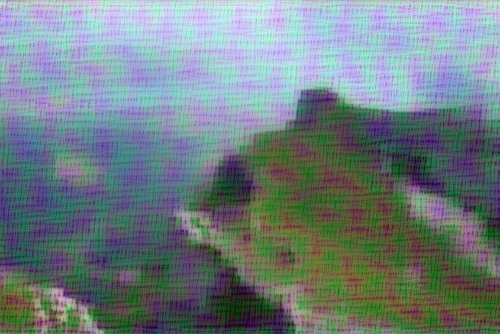

梦醒时分....... 耗时: 163.3444790840149
图片己保存为：dream_tile_octave_['conv2d_15', 'conv2d_18'].jpg


In [16]:
start = time.time()
print ("开始做梦.....")

img = tf.keras.applications.inception_v3.preprocess_input(img_mountain)
img = tf.convert_to_tensor(img)
img = render_deepdream_with_octaves(dream_model, img, steps_per_octave=50, step_size=0.01, octaves=range (-2, 3), octave_scale=1.3)
show_image(img)

end = time.time()
print("梦醒时分....... 耗时:", end-start)

file_name = 'dream_tile_octave_{}.jpg'.format(layer_names)
save_image(img, file_name)
print('图片己保存为：{}'.format(file_name))